In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, window_size = 960, threshold_value = 0.2):
    """
    优化后的聪明钱因子计算 (支持四种新的S值构造方式)
    优化点:
    1. 预计算所有必要列（避免重复计算）
    2. 使用滚动窗口向量化操作
    3. 使用numpy替代pandas进行窗口内计算
    4. 避免在循环中创建临时Series
    
    新增四种S值构造方式:
    1. S = |R| / (V × σᵥ)   (成交量波动率调整)
    2. S = |R| × (taker_buy_volume / volume)  (主动买入比例)
    3. S = |R| / √(trade_count)  (交易笔数调整)
    4. S = |R| × e^(-β/V)   (指数衰减函数)
    """
    # ========== 选择要使用的S值计算方法 (修改这里的数字即可切换) ==========
    S_METHOD = 3  # 可选值: 1, 2, 3, 4
    
    # 预计算所有必要值
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    avg_price_vals = avg_price.values
    
    abs_ret = abs((df['close'] - df['open']) / df['open'])
    volume = df['volume'].values
    
    # ========== 根据选择的方法计算S值 ==========
    if S_METHOD == 1:
        # 方法1: S = |R| / (V × σᵥ)
        # 计算成交量波动率 (20期标准差)
        vol_std = df['volume'].rolling(20, min_periods=1).std().shift(1).fillna(0.001)
        S_values = abs_ret.values / (volume * vol_std.values + 1e-9)  # 避免除零
    
    elif S_METHOD == 2:
        # 方法2: S = |R| × (taker_buy_volume / volume)
        # 计算主动买入比例
        buy_ratio = df['taker_buy_volume'] / (df['volume'] + 1e-9)
        S_values = abs_ret.values * buy_ratio.values
    
    elif S_METHOD == 3:
        # 方法3: S = |R| / √(trade_count)
        # 使用交易笔数
        sqrt_trade = np.sqrt(df['trade_count'])
        S_values = abs_ret.values / (sqrt_trade.values + 1e-9)  # 避免除零
    
    elif S_METHOD == 4:
        # 方法4: S = |R| × e^(-β/V)
        # β参数设置 (推荐范围0.5-2)
        beta = 1.0  
        # 指数衰减计算 (对小成交量更敏感)
        exp_factor = np.exp(-beta / (volume + 1e-9))  # 避免除零
        S_values = abs_ret.values * exp_factor
    
    else:
        raise ValueError("无效的S_METHOD值，必须是1-4")
    
    # 初始化因子值数组
    factor_values = np.full(len(df), np.nan)
    
    # 使用滑动窗口计算
    for i in range(window_size, len(df)):
        # 获取当前窗口切片索引
        start_idx = i - window_size
        end_idx = i - 1
        
        # 提取当前窗口数据
        window_avg_price = avg_price_vals[start_idx:end_idx]
        window_volume = volume[start_idx:end_idx]
        window_S = S_values[start_idx:end_idx]
        
        # 按S值降序排序的索引
        sorted_idx = np.argsort(-window_S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # 计算累积成交量
        cum_volume = np.cumsum(sorted_volume)
        total_volume = cum_volume[-1]
        threshold = total_volume * threshold_value
        
        # 找到聪明钱交易点 (前20%成交量)
        smart_mask = cum_volume <= threshold
        if np.any(smart_mask):
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                               sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
        else:
            smart_vwap = np.nan
        
        # 计算整体VWAP
        all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
        
        # 计算因子值
        if not np.isnan(smart_vwap) and all_vwap != 0:
            factor_values[i] = smart_vwap / all_vwap
            
    return pd.Series(factor_values, index=df.index)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.016723
   Rank_IC (Spearman): 0.019661
📊 信息比率:
   IR: 0.377188
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130075
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


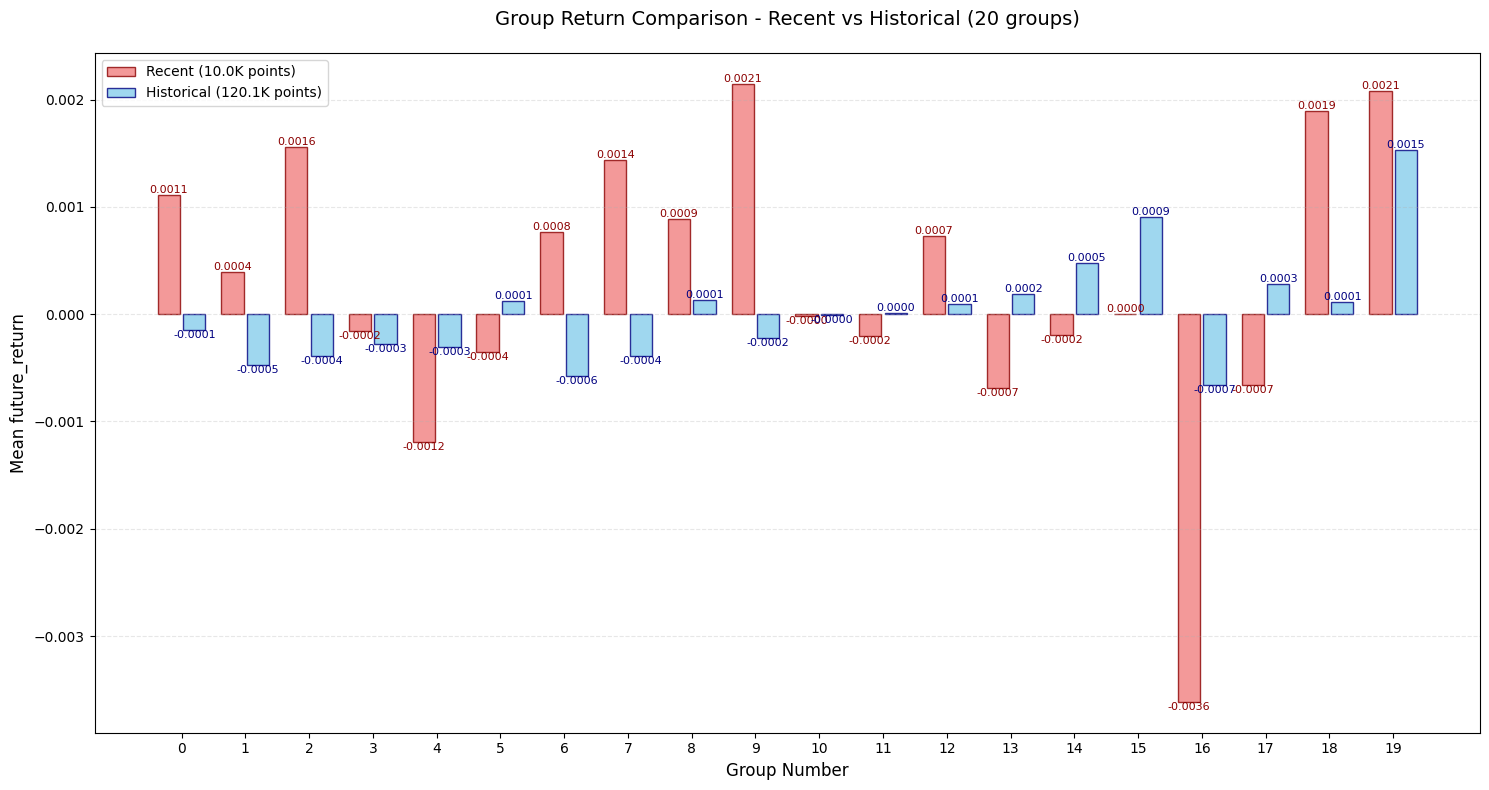

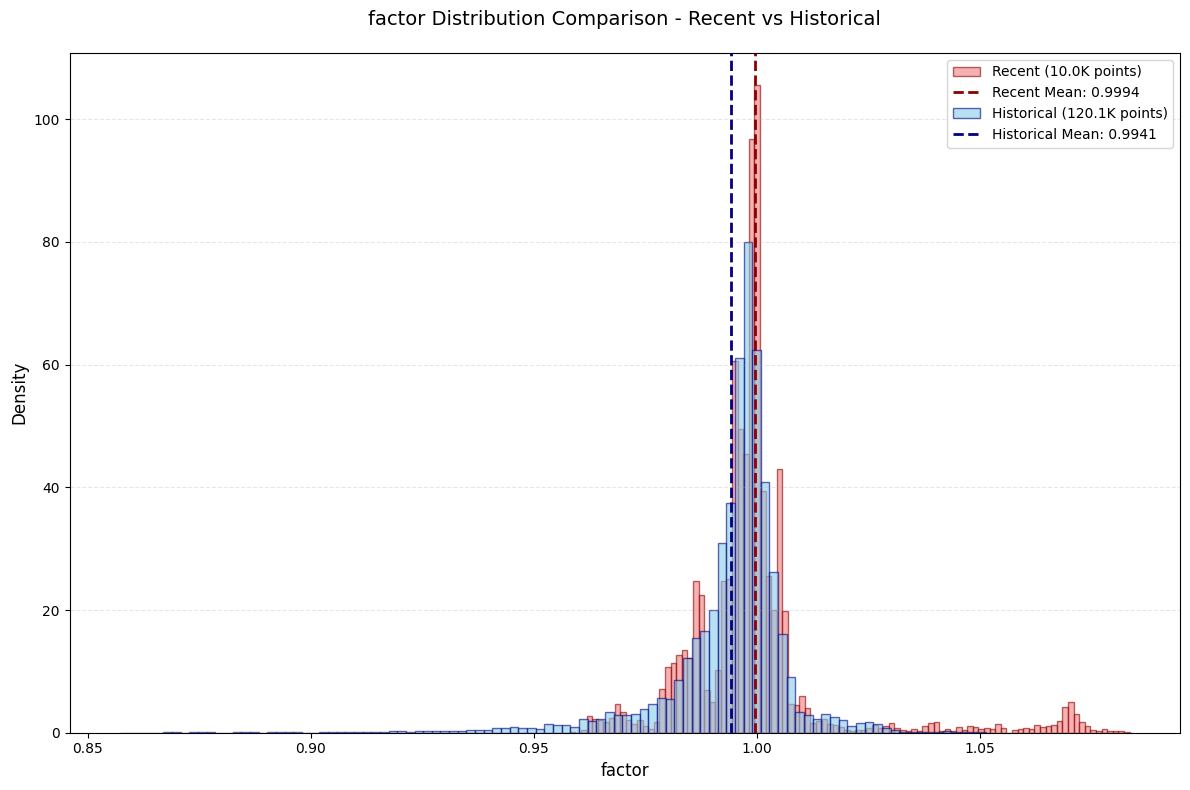

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

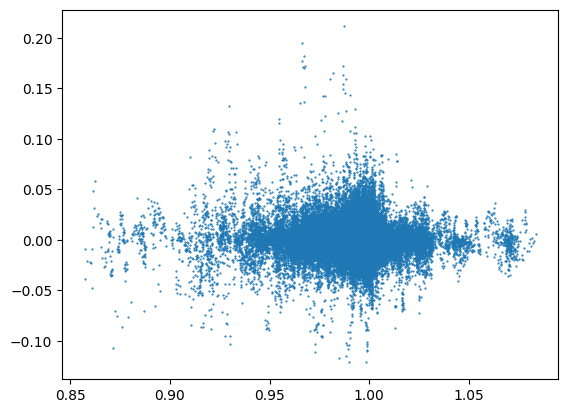

In [6]:
import matplotlib.pyplot as plt
plt.scatter(factor(df),df['close'].pct_change(-10), s=0.3)

In [7]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.02180549391347538,
 0.0026104583335890843,
 0.0015059582090229738,
 0.012292046141477976,
 -0.01186262724470391,
 0.0030183274928830333,
 -0.0053441361415681645,
 0.012952428717489481,
 0.030205432327077862,
 0.052741616974651476]

In [8]:
print(result)

{'correlation_analysis': {'IC': 0.016723217803503592, 'Rank_IC': 0.01966055416169946}, 'information_ratio': {'IR': 0.3771881916204155, 'group_correlations': [-0.02180549391347538, 0.0026104583335890843, 0.0015059582090229738, 0.012292046141477976, -0.01186262724470391, 0.0030183274928830333, -0.0053441361415681645, 0.012952428717489481, 0.030205432327077862, 0.052741616974651476], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.8573   0.9692    0.9508      -0.0002      0.0211   6504
1       0.9692   0.9812    0.9762      -0.0003      0.0162   6504
2       0.9812   0.9859    0.9838      -0.0002      0.0115   6504
3       0.9859   0.9889    0.9874      -0.0002      0.0128   6503
4       0.9889   0.9915    0.9903      -0.0004      0.0123   6504
5       0.9915   0.9931    0.9923       0.0001      0.0114   6504
6       0.9931   0.9945    0.9938    